In [1]:
# build the networks
using LinearAlgebra
using SparseArrays
using Combinatorics
using EzXML
include("all_code/code_needed.jl")
# 3dprinting.meta.stackexchange.com
posts_doc = readxml("3dprinting.meta.stackexchange.com/Posts.xml")
comments_doc = readxml("3dprinting.meta.stackexchange.com/Comments.xml")

# posts_doc = readxml("arabic.meta.stackexchange.com/Posts.xml")
# comments_doc = readxml("arabic.meta.stackexchange.com/Comments.xml")

┌ Info: Recompiling stale cache file /homes/hnassar/.julia/compiled/v1.0/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1184
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Optim [429524aa-4258-5aef-a3af-852621145aeb]
│   exception = Required dependency LineSearches [d3d80556-e9d4-5f37-9878-2ab0fcc64255] failed to load from a cache file.
└ @ Base loading.jl:963
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
│   exception = ErrorException("Required dependency KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b] failed to load from a cache file.")
└ @ Base loading.jl:963


EzXML.Document(EzXML.Node(<DOCUMENT_NODE@0x000000000466cff0>))

In [2]:
allposts = root(posts_doc)
alltags = Array{String}(undef,0)
postids = Array{Int}(undef,0)
ownerids = Array{Int}(undef,0)
posttags = Array{Array{String}}(undef,0)
postanswers = Array{Array{Int}}(undef,0)
postcomments = Array{Array{Int}}(undef,0)
remainderposts = Array{EzXML.Node}(undef,0)


answersid = Array{Int}(undef,0)
answersownerid = Array{Int}(undef,0)

for post in eachelement(allposts)
    if haskey(post,"OwnerUserId")
        # Get an attribute value by name.
        if parse(Int,post["PostTypeId"]) == 1 # it was a question
            postid = parse(Int,post["Id"])
            ownerid = parse(Int,post["OwnerUserId"])
            tags = unique(reduce(vcat, split.(split(post["Tags"],"<"),">")))[2:end]

            push!(postids,postid)
            push!(ownerids,ownerid)
            push!(posttags,tags)
            push!(postanswers,Vector{Int}(undef,0))
            push!(postcomments,Vector{Int}(undef,0))
        else # it was an answer
            if haskey(post,"ParentId")
                parentid = findfirst(postids.==parse(Int,post["ParentId"]))
                if parentid == nothing
                    push!(remainderposts,post)
                else
                    ownerid = parse(Int,post["OwnerUserId"])
                    push!(postanswers[parentid],ownerid)
                    push!(answersid,parse(Int,post["Id"]))
                    push!(answersownerid,ownerid)
                end
            end
        end
    end
end
# remainderposts
remainderposts2 = Array{EzXML.Node}(undef,0)
for post in remainderposts
    parentid = findfirst(postids.==parse(Int,post["ParentId"]))
    if parentid == nothing
        push!(remainderposts2,post)
    else
        ownerid = parse(Int,post["OwnerUserId"])
        push!(postanswers[parentid],ownerid)
        push!(answersid,parse(Int,post["Id"]))
        push!(answersownerid,ownerid)
    end
end
remainderposts2; # these will get discarded as the parent is not found

In [3]:
# allposts = root(posts_doc)
# alltags = Array{String}(undef,0)
# postids = Array{Int}(undef,0)
# ownerids = Array{Int}(undef,0)
# posttags = Array{Array{String}}(undef,0)
# postanswers = Array{Array{Int}}(undef,0)
# remainderposts = Array{EzXML.Node}(undef,0)


# form triangles between:
# ownerids,postanswers,posttags

In [4]:
commentanswernode = Array{Array{Int}}(undef,length(answersid))
map(i->commentanswernode[i]=[],1:length(commentanswernode))
# answersownerid - commentanswernode are the edges within A
# ownserids - postcomments are edges within Q
# postags are edges within each group (T)

# ownerids - postanswers - posttags are the intermodal links
;

In [5]:
# read comments.xml

allcomments = root(comments_doc)
for comment in eachelement(allcomments)
    if haskey(comment,"UserId")
        uid = parse(Int,comment["UserId"])
        id = findfirst(postids.==parse(Int,comment["PostId"]))
        if id != nothing
            push!(postcomments[id],uid)
        else 
            id = findfirst(answersid.==parse(Int,comment["PostId"]))
            if id != nothing
                push!(commentanswernode[id],uid)
            end
            # else discard
        end
    end
end

In [6]:
utags = unique(reduce(vcat,posttags))
nT = length(utags)
uquestions = unique(vcat(unique(reduce(vcat,postcomments)),unique(ownerids)))
nQ = length(uquestions)
uanswers = unique(vcat(unique(reduce(vcat,commentanswernode)),unique(answersownerid)))
nA = length(uanswers)

@show nT,nQ,nA

(nT, nQ, nA) = (30, 64, 58)


(30, 64, 58)

In [7]:
# mapping is if tag/q/a is i, then original id is utags[i]/uquestions[i]/uanswers[i]
# time to build 6 networks

# 1 # Tag-Tag
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for tagbundle in posttags
    newids = findin_index(tagbundle,utags)
    for comb in combinations(newids,2)
        push!(ei,comb[1])
        push!(ej,comb[2])
    end
end
TagTag = spones(sparse(ei,ej,1,nT,nT))
TagTag = max.(TagTag,TagTag')
;

In [8]:
# 2 # Question - Tag
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(ownerids)
    id = ownerids[i]
    oid = findfirst(uquestions.==id)
    tagbundle = posttags[i]
    newidstags = findin_index(tagbundle,utags)
    for ti in newidstags
        push!(ei,oid)
        push!(ej,ti)
    end
end
QuestionTag = spones(sparse(ei,ej,1,nQ,nT));

In [9]:
# 3 # Question - Answers
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(ownerids)
    id = ownerids[i]
    oid = findfirst(uquestions.==id)
    answersbundle = postanswers[i]
    newidsanswers = findin_index(answersbundle,uanswers)
    for ti in newidsanswers
        push!(ei,oid)
        push!(ej,ti)
    end
end
QuestionAnswer = spones(sparse(ei,ej,1,nQ,nA));

In [10]:
# 4 # Question - Question
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(ownerids)
    id = ownerids[i]
    oid = findfirst(uquestions.==id)
    commentsbundle = postcomments[i]
    newidsquestions = findin_index(commentsbundle,uquestions)
    for ti in newidsquestions
        push!(ei,oid)
        push!(ej,ti)
    end
end
QuestionQuestion = spones(sparse(ei,ej,1,nQ,nQ));
QuestionQuestion = max.(QuestionQuestion,QuestionQuestion');

In [11]:
# 5 # Answer - Tag
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(postanswers)
    ai = postanswers[i]
    ti = posttags[i]
    newids_answers = findin_index(ai,uanswers)
    newids_tags = findin_index(ti,utags)
    for answerid in newids_answers
        for tagid in newids_tags
            push!(ei,answerid)
            push!(ej,tagid)
        end
    end
end
AnswerTag = spones(sparse(ei,ej,1,nA,nT));

In [12]:
# 6 # Answer - Answer
# Part 1
# answersownerid - commentanswernode
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for i = 1:length(answersownerid)
    id = answersownerid[i]
    oid = findfirst(uanswers.==id)
    commentbundle = commentanswernode[i]
    newidsanswers = findin_index(commentbundle,uanswers)
    for ti in newidsanswers
        push!(ei,oid)
        push!(ej,ti)
    end
end
AnswerAnswer1 = spones(sparse(ei,ej,1,nA,nA))

# Part 2
ei = Vector{Int}(undef,0)
ej = Vector{Int}(undef,0)
for answerbundle in postanswers
    newids = findin_index(answerbundle,uanswers)
    for comb in combinations(newids,2)
        push!(ei,comb[1])
        push!(ej,comb[2])
    end
end
AnswerAnswer2 = spones(sparse(ei,ej,1,nA,nA))

AnswerAnswer = AnswerAnswer1+AnswerAnswer2
AnswerAnswer = max.(AnswerAnswer,AnswerAnswer')

58×58 SparseMatrixCSC{Int64,Int64} with 319 stored entries:
  [2 ,  1]  =  1
  [7 ,  1]  =  1
  [10,  1]  =  1
  [12,  1]  =  1
  [13,  1]  =  1
  [19,  1]  =  1
  [49,  1]  =  1
  [1 ,  2]  =  1
  [2 ,  2]  =  1
  [3 ,  2]  =  1
  [4 ,  2]  =  1
  [10,  2]  =  1
  ⋮
  [2 , 51]  =  1
  [25, 53]  =  1
  [25, 54]  =  1
  [31, 54]  =  1
  [31, 55]  =  1
  [31, 56]  =  1
  [4 , 57]  =  1
  [24, 57]  =  1
  [29, 57]  =  1
  [31, 58]  =  1
  [38, 58]  =  1
  [47, 58]  =  1

In [13]:
A = vcat(hcat(QuestionQuestion,QuestionAnswer,QuestionTag),
    hcat(QuestionAnswer',AnswerAnswer,AnswerTag),
    hcat(QuestionTag',AnswerTag',TagTag))

152×152 SparseMatrixCSC{Int64,Int64} with 1502 stored entries:
  [1  ,   1]  =  1
  [8  ,   1]  =  1
  [9  ,   1]  =  1
  [10 ,   1]  =  1
  [40 ,   1]  =  1
  [72 ,   1]  =  1
  [126,   1]  =  1
  [127,   1]  =  1
  [3  ,   2]  =  1
  [4  ,   2]  =  1
  [14 ,   2]  =  1
  [17 ,   2]  =  1
  ⋮
  [106, 151]  =  1
  [123, 151]  =  1
  [138, 151]  =  1
  [141, 151]  =  1
  [146, 151]  =  1
  [152, 151]  =  1
  [15 , 152]  =  1
  [95 , 152]  =  1
  [123, 152]  =  1
  [138, 152]  =  1
  [141, 152]  =  1
  [151, 152]  =  1

In [14]:
n0 = [nQ,nA,nT]
M = create_subnetworks(A,3,n0);
M0 = A
M1 = vcat(hcat(spzeros(M[1]),M[2]',M[4]'),hcat(M[2],spzeros(M[3]),M[5]'),hcat(M[4],M[5],spzeros(M[6])));

In [15]:
#initialize a few things
#keeping the data as it is and running double seeded PageRank on all existing triangles

myalpha = 0.8
curM = copy(A) # the adjacency matrix of the full network

@time i1,j1,TR = find_edges_of_tris(M);
tensor_ids_sample = hcat(i1,j1)# equivalent to: unique(tensor_ids[:,1:2],dims=1)

exps = length(i1)
all_aucs = zeros(exps)
all_aucs1 = zeros(exps)
all_aucs2 = zeros(exps)
all_aucs3 = zeros(exps)
all_aucs4 = zeros(exps)
for ii = 1:exps
    # the vectors to potentially use as seed vectors
    v = spzeros(size(curM,2))
    vi = copy(v)
    vj = copy(v)
    
    rw = tensor_ids_sample[ii,:] # pick the pair to seed on
    i = rw[1]
    j = rw[2]
    jm = n0[1] + j # map back to the full network
    
    # use v to pair seed
    v[i] = 0.5
    v[jm] = 0.5
    
    # vi to single seed
    vi[i] = 1
    
    # vj to single seed
    vj[jm] = 1
    
    ism = TR[ii,:] 
    k_ids = ism.nzind # this is everything that i and jm form triangles with
    
    xrefreal = zeros(Int64,n0[3])
    xrefreal[k_ids] .= 1
    
    xsol = seeded_pagerank(curM,myalpha,v)
    xsol1 = seeded_pagerank(curM,myalpha,vi)
    xsol2 = seeded_pagerank(curM,myalpha,vj)
    
    xsol3 = xsol1.*xsol2 # "and"
    xsol4 = xsol1.+xsol2 # "or"
    
    xk = xsol[n0[1]+n0[2]+1:end] # double seed
    xk1 = xsol1[n0[1]+n0[2]+1:end] # single seed 1
    xk2 = xsol2[n0[1]+n0[2]+1:end] # single seed 2
    xk3 = xsol3[n0[1]+n0[2]+1:end] # "and"
    xk4 = xsol4[n0[1]+n0[2]+1:end] # "or"
    
    fpr,tpr,auc = calc_AUC_new(xrefreal,xk)
    fpr,tpr,auc1 = calc_AUC_new(xrefreal,xk1)
    fpr,tpr,auc2 = calc_AUC_new(xrefreal,xk2)
    fpr,tpr,auc3 = calc_AUC_new(xrefreal,xk3)
    fpr,tpr,auc4 = calc_AUC_new(xrefreal,xk4)
    
    all_aucs[ii] = auc
    all_aucs1[ii] = auc1
    all_aucs2[ii] = auc2
    all_aucs3[ii] = auc3
    all_aucs4[ii] = auc4
end

  1.147671 seconds (1.74 M allocations: 84.257 MiB, 7.12% gc time)


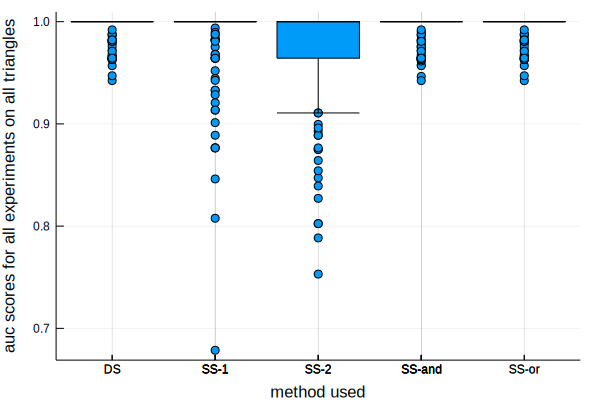

In [16]:
# plot the distributions of the auc scores
# pyplot()
aucvals = hcat(all_aucs,all_aucs1,all_aucs2,all_aucs3,all_aucs4)
aucvals = aucvals'[:]
boxplot(["DS","SS-1","SS-2","SS-and","SS-or"],aucvals,leg=false)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")
# savefig("exp0-sanity-synthetic-1000-b-w.pdf") b = between communitites, w = within community
# savefig("exp0-sanity-synthetic-1000-1-9.pdf")

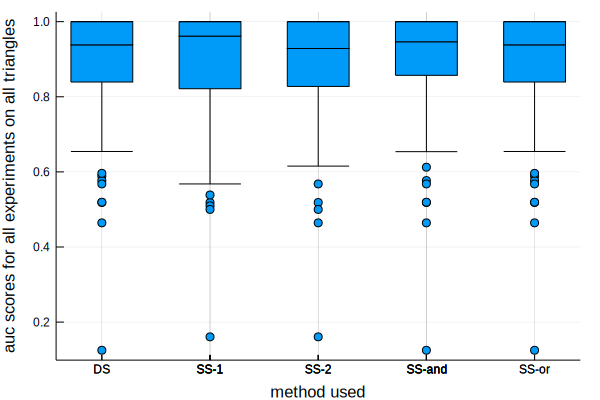

In [25]:
include("all_code/code_needed.jl")
all_aucs_new = general_double_seed_idea(
    M,
    n0,
    "edge",#"edge","triangle"
    1.0,
    0.8,
    A);

aucvals = all_aucs_new
boxplot(["DS" "SS-1" "SS-2" "SS-and" "SS-or"],aucvals, legend = false,color=1)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")

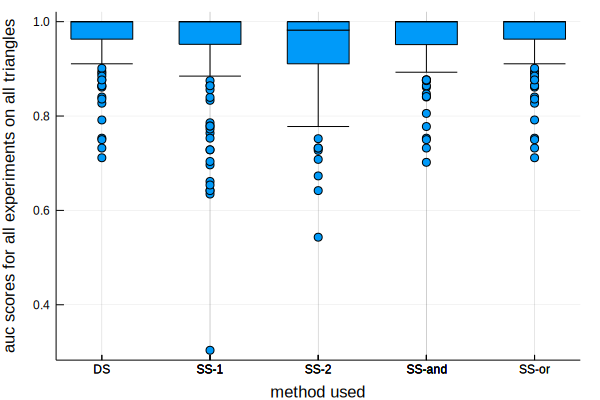

In [26]:
include("all_code/code_needed.jl")
all_aucs_new = general_double_seed_idea(
    M,
    n0,
    "wedge",#"edge","triangle"
    1.0,
    0.8,
    A);

aucvals = all_aucs_new
boxplot(["DS" "SS-1" "SS-2" "SS-and" "SS-or"],aucvals, legend = false,color=1)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")

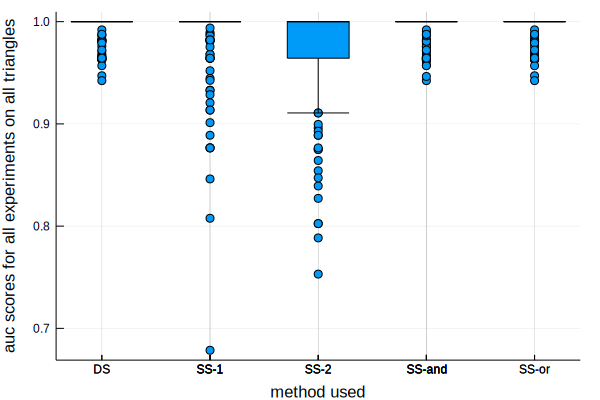

In [27]:
include("all_code/code_needed.jl")
all_aucs_new = general_double_seed_idea(
    M,
    n0,
    "triangle",#"edge","triangle"
    1.0,
    0.8,
    A);

aucvals = all_aucs_new
boxplot(["DS" "SS-1" "SS-2" "SS-and" "SS-or"],aucvals, legend = false,color=1)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")

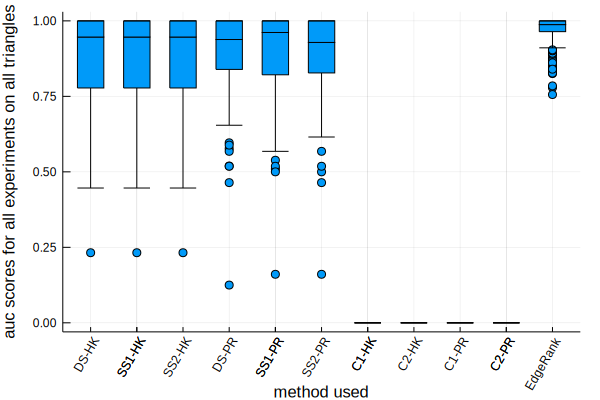

In [28]:
include("all_code/methods.jl")
all_aucs_new = general_double_seed_idea_all_methods(
    M,
    n0,
    "edge",#"edge","triangle"
    1.0,
    0.8,
    A);

aucvals = all_aucs_new
boxplot(["DS-HK" "SS1-HK" "SS2-HK" "DS-PR" "SS1-PR" "SS2-PR" "C1-HK" "C2-HK" "C1-PR" "C2-PR" "EdgeRank"],aucvals, legend = false,color=1)
xlabel!("method used")
ylabel!("auc scores for all experiments on all triangles")
plot!(xrotation=60)